## Validation of micro solvers



In [1]:
import sys
sys.path.append("/home/emastr/phd/")
from boundary_solvers.geometry import RoundedMicroGeomGeneric, Geometry
from boundary_solvers.gauss_grid_2d import StokesDirichletProblem, GaussLegGrid
import numpy as np
import matplotlib.pyplot as plt

In [15]:
def microbox(**kwargs):
    k = 10
    width = 0.1
    height = 0.1
    center = 1+2j
    normal = -(1+1j)/2**0.5
    corner_w = 0.02
    eps = 0.01

    func = lambda t: np.sin(k*t) * eps + eps * 4.
    dfunc = lambda t: k*np.cos(k*t) * eps
    ddfunc = lambda t: -k**2*np.sin(k*t) * eps
    
    geom = RoundedMicroGeomGeneric(func, dfunc, ddfunc, center, width, height, normal, corner_w, **kwargs)
    
    a = geom.line_left
    b = geom.line_right
     
    return geom, a, b

def circle(**kwargs):
    c = 1+2j
    z = lambda t: c + np.exp(1j*t)
    dz = lambda t: 1j*np.exp(1j*t)
    ddz = lambda t: -np.exp(1j*t)
    
    grid = GaussLegGrid(np.linspace(0, 2*np.pi, 2))
    grid.refine_all_nply(kwargs.get('n_refine', 0))
    geom = Geometry([z, dz, ddz], grid)
    
    #a = np.exp(1j*np.pi*5/4)/1.2 + c
    #b = np.exp(1j*np.pi*7/4)/1.2 + c
    theta = -0.1 * np.pi
    a = np.exp(1j*(np.pi+theta))/1.2 + c
    b = np.exp(1j*(-theta))/1.2 + c
     
    return geom, a, b

def test_adjoint(geometry, a, b, n_refine_line):
        
    solution = lambda z: np.conjugate(z)
    condition = lambda t: solution(geometry.eval_param(t=t))
        
    avg = (b**2 - a**2).real/2
    davg = -((b - a)**2).imag/abs(b - a)
    dz = geometry.eval_param(derivative=1)
    
    ## Computations using the adjoint
    if hasattr(geometry, 'line_left'):
        a_vec, avgFunc = geometry.precompute_line_avg(derivative=0,tol=1e-14, maxiter=50)
        _, avgFuncDer = geometry.precompute_line_avg(derivative=1,tol=1e-14, maxiter=50)
    else:
        a_vec, avgFunc = geometry.precompute_line_avg(a, b, derivative=0,tol=1e-14, maxiter=50)
        _, avgFuncDer = geometry.precompute_line_avg(a, b, derivative=1,tol=1e-14, maxiter=50)
        
    t, _ = geometry.grid.get_grid_and_weights()
    avg_adj = avgFunc(condition(t))
    davg_adj = avgFuncDer(condition(t))
    delta_adj = abs(avg_adj - avg)
    ddelta_adj = abs(davg_adj - davg)
    
    ## Computations using the forward
    problem = StokesDirichletProblem(geometry, condition)
    problem.solve(tol=1e-14, maxiter=50)
    grid = GaussLegGrid(np.linspace(0, 1, 2))
    grid.refine_all_nply(n_refine_line)
    et_c = np.conjugate((b - a) / abs(b - a))
    u_dot_et = lambda t: np.real(et_c * problem.evaluate(a + (b - a) * t[:, None]) * abs(b-a))
    
    avg_fwd = grid.integrate(u_dot_et)
    delta_fwd = abs(avg_fwd - avg)
    
    print(f'avg={avg_adj}, error={delta_adj}')
    print(f'avg={avg_fwd}, error={delta_fwd}')
    print(f'davg={davg_adj}, error={ddelta_adj}')
    
    # Riesz representator as velocity field
    condition = lambda t: a_vec / 1j
    problem_riesz = StokesDirichletProblem(geometry, condition)
    problem_riesz.solve(tol=1e-14, maxiter=50)
    
    return problem, problem_riesz

In [16]:
geom, a, b = circle(n_refine=3, n_corner_refine=0)
problem, problem_riesz = test_adjoint(geom, a, b, n_refine_line=5)

avg=1.5850940760505479, error=1.177747079861291e-07
avg=1.5850940760505474, error=1.1777470843021831e-07
davg=-3.7389321565495237e-06, error=3.7389321565495237e-06


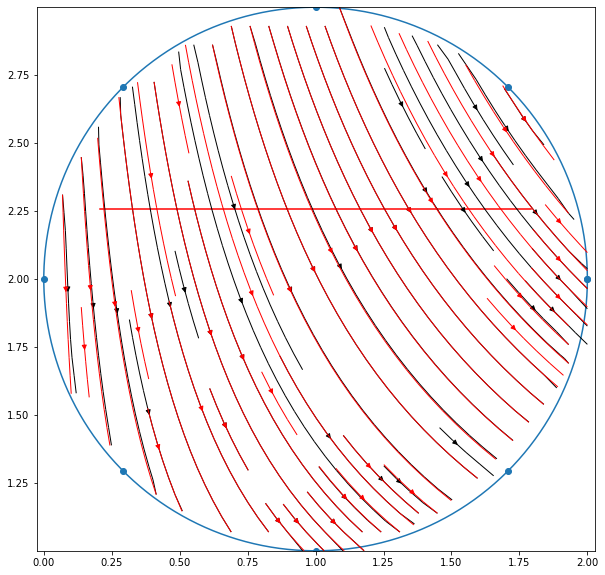

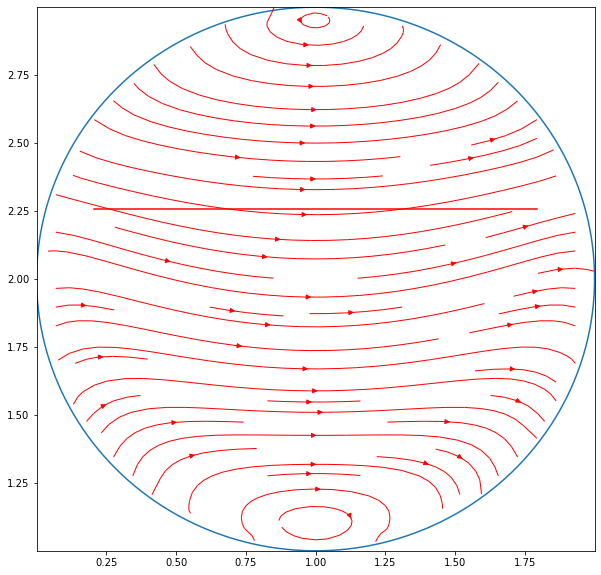

In [17]:
plt.figure(figsize=(10,10))
geom.plot(plt.gca(), showsegments=True)
plt.plot([np.real(a), np.real(b)], [np.imag(a), np.imag(b)], 'r')
problem.geometry.plot_stream(ax=plt.gca(), func=problem.evaluate, apply_mask=True, color='black', linewidth=1)
problem.geometry.plot_stream(ax=plt.gca(), func=lambda z: np.conj(z), apply_mask=True, color='red', linewidth=1)
plt.axis('equal')

plt.figure(figsize=(10,10))
geom.plot(plt.gca())
plt.plot([np.real(a), np.real(b)], [np.imag(a), np.imag(b)], 'r')
problem.geometry.plot_stream(ax=plt.gca(), func=problem_riesz.evaluate, apply_mask=True, color='red', linewidth=1)